# Stock price
- Collect stock price from internet
- compare two stock price 
- In this file, I compare kakao and naver stocks.

In [2]:
import pandas as pd
import urllib3,certifi
import matplotlib.pyplot as plt

#### Data load from Naver finances

In [3]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

In [5]:
code_df.head(3)

,name,code
0,CJ,001040
1,CJ씨푸드,011150
2,HSD엔진,082740


In [6]:
def get_code (item_name, code_df=code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    return code

In [7]:
get_code('카카오')

'035720'

In [6]:
# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    url = 'https://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)

    return url

def get_stock_data(item_name, code_df = code_df, n_pages=20):
    url = get_url(item_name, code_df)

    #Force certificate check and use certifi to handle the certificate. 
    https = urllib3.PoolManager( cert_reqs='CERT_REQUIRED',
        ca_certs=certifi.where(),)  

    # 일자 데이터를 담을 df라는 DataFrame 정의
    df = pd.DataFrame()

    # 1페이지에서 20페이지의 데이터만 가져오기
    for page in range(1, n_pages + 1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        #print('url: ', pg_url)
        https_url = https.urlopen('GET', pg_url) #' https://naver.com')  
        df = df.append(pd.read_html(https_url.data, header=0)[0], ignore_index=True)

    # df.dropna()를 이용해 결측값 있는 행 제거
    df = df.dropna()
    return df

In [7]:
#code_df
get_code('카카오')

'035720'

In [8]:
df_naver = get_stock_data('NAVER', n_pages=60)

In [9]:
df_kakao = get_stock_data('카카오', n_pages=60)

In [10]:
df_kakao.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
1,2018.11.30,112500.0,500.0,112000.0,113000.0,111500.0,346395.0
2,2018.11.29,112000.0,0.0,113000.0,114000.0,111000.0,263008.0
3,2018.11.28,112000.0,1500.0,111500.0,113000.0,111000.0,185906.0


In [11]:
df_naver.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
1,2018.11.30,126500.0,4000.0,131000.0,131000.0,126000.0,800935.0
2,2018.11.29,130500.0,1500.0,133000.0,134000.0,129000.0,559552.0
3,2018.11.28,129000.0,4000.0,128500.0,130500.0,126500.0,645902.0


In [143]:
#df_kakao.info()
#df_naver.info()

In [12]:
df2 = pd.DataFrame()
#df2['date'] = df_naver['날짜']
#df2['naver'] =  df_naver['종가']
df2['naver'] =  df_naver['시가']
df2['kakao'] = df_kakao['시가']

In [13]:
df2['date'] = df_naver['날짜']
df2.date = pd.to_datetime(df2.date)
df2 =df2.set_index('date')

In [14]:
df2 = df2.sort_index()

In [15]:
df2.head(3)

,naver,kakao
date,,
2016-06-22,699000.0,93300.0
2016-06-23,733000.0,93800.0
2016-06-24,745000.0,94500.0


## Make K5 index level 
- Set first day's value as 1 then nomailze via first day's value
- Index value = (value) / (value of first day)

In [17]:
df2_index = df2.apply(lambda x: x / x[0])

In [18]:
df2_index.head(3)

,naver,kakao,ratio
date,,,
2016-06-22,1.000000,1.000000,1.000000
2016-06-23,1.048641,1.005359,1.043051
2016-06-24,1.065808,1.012862,1.052274


<Figure size 1080x360 with 0 Axes>

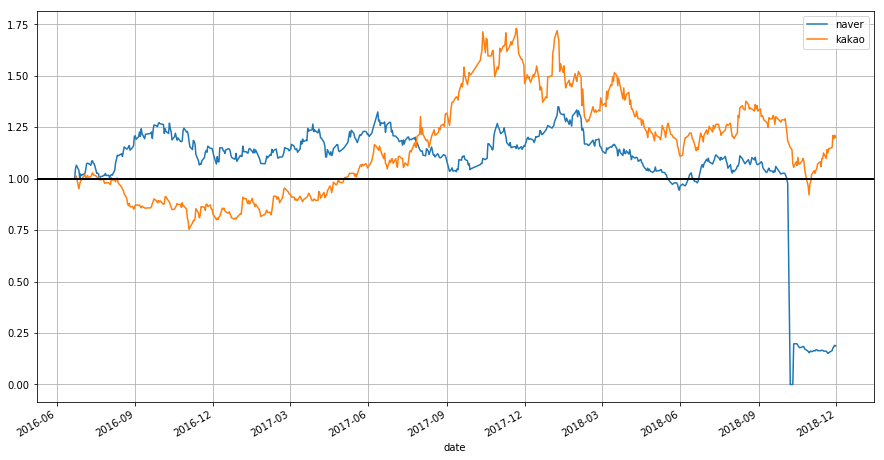

In [26]:
plt.figure(figsize=(15, 5))
df2_index[['naver', 'kakao']].plot(grid = True, figsize = (15, 8)).axhline(y = 1, color = "black", lw = 2)


## Plot scatter


(0.8, 1.4)

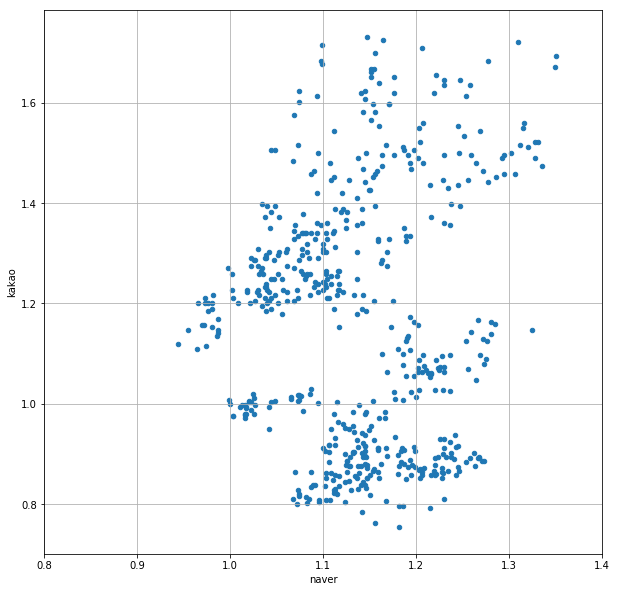

In [31]:
df2_index.plot.scatter(x='naver', y='kakao',  grid= True, figsize = (10, 10))
plt.xlim(0.8, 1.4)

In [16]:
df2['ratio'] = df2['naver'] / df2['kakao']

In [18]:
df2['avg_ratio'] = df2['ratio'].rolling(window=20, min_periods=1).mean()

In [19]:
df2.head(3)

,naver,kakao,ratio,avg_ratio
date,,,,
2016-03-24,638000.0,106600.0,5.984991,5.984991
2016-03-25,624000.0,106500.0,5.859155,5.922073
2016-03-28,616000.0,101700.0,6.057030,5.967059


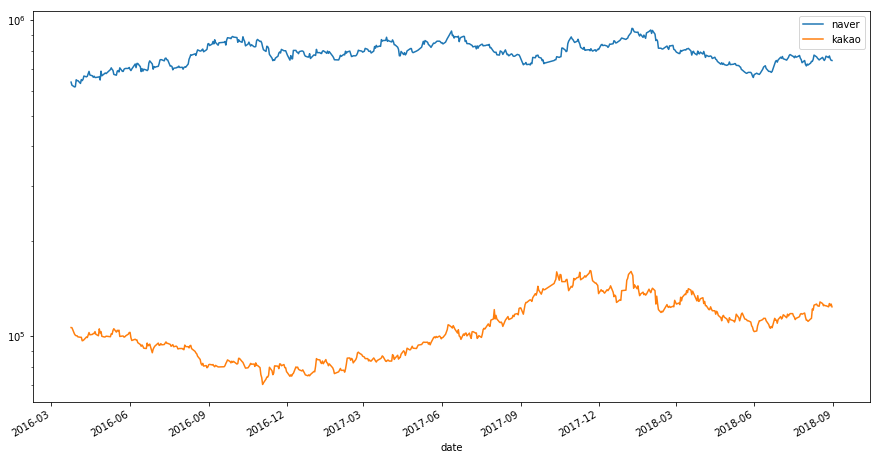

In [20]:
#df2.adropna()
#plt.figure(figsize=(15, 8))
df2.plot(y = ['naver', 'kakao'], logy=True, figsize = (15, 8))

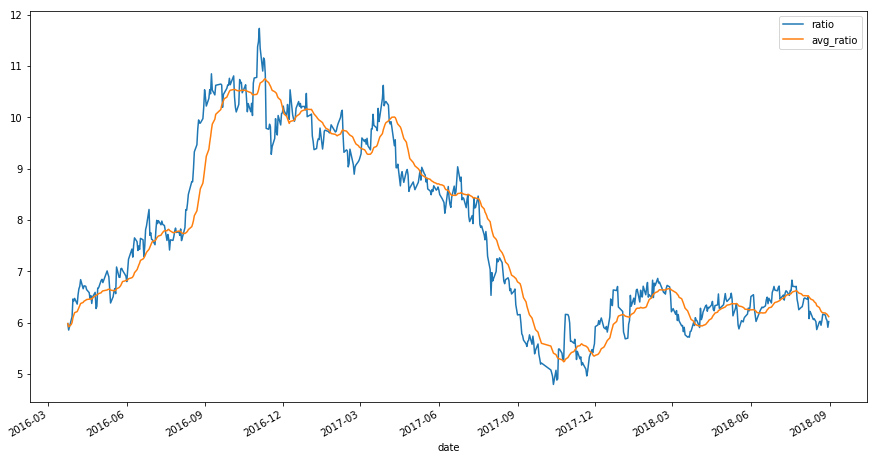

In [21]:
df2.plot(y=['ratio', 'avg_ratio'], figsize = (15, 8))

In [22]:
df2.corr()

,naver,kakao,ratio,avg_ratio
naver,1.000000,0.114494,0.327795,0.306571
kakao,0.114494,1.000000,-0.885910,-0.861982
ratio,0.327795,-0.885910,1.000000,0.968119
avg_ratio,0.306571,-0.861982,0.968119,1.000000


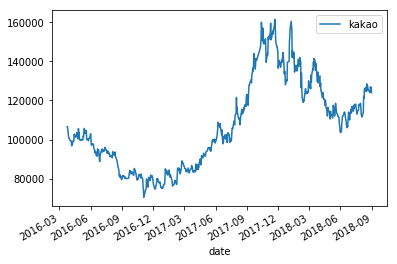

In [23]:
df2.plot(y='kakao')

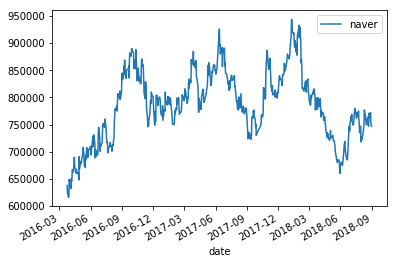

In [27]:
df2.plot(y='naver')

In [24]:
df2['diff'] = df2['naver'] - df2['kakao']

In [25]:
df2.head(3)

,naver,kakao,ratio,avg_ratio,diff
date,,,,,
2016-03-24,638000.0,106600.0,5.984991,5.984991,531400.0
2016-03-25,624000.0,106500.0,5.859155,5.922073,517500.0
2016-03-28,616000.0,101700.0,6.057030,5.967059,514300.0


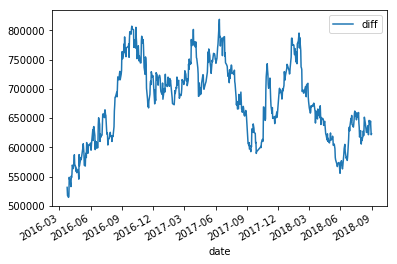

In [26]:
df2.plot(y='diff')